# My own model

In [1]:
# pipelines/smart_pandas.py

import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from sklearn.pipeline import FeatureUnion, _fit_transform_one, _transform_one
from scipy import sparse

class PandasFeatureUnion(FeatureUnion):
    """
    PandasFeatureUnion inherit from sklearn FeatureUnion to create a pipeline \
for feature engineering that return pandas.DataFrame.
    """

    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(
                transformer=trans, X=X, y=y, weight=weight, **fit_params
            )
            for name, trans, weight in self._iter()
        )

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(transformer=trans, X=X, y=None, weight=weight)
            for name, trans, weight in self._iter()
        )
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs


In [2]:
# pipelines/base_estimators.py
import pandas as pd

class CustomBase:
    
    def __init__(self, verbose=False):
        self.verbose = verbose
        
    def data_info(self, data:pd.DataFrame, sorted:bool=False) -> pd.DataFrame:
        """
        Function to describe the variables of a dataframe
        Analogous to the .describe() method of pandas.DataFrame
        """
        df = pd.DataFrame(pd.Series(data.columns))
        df.columns = ["columna"]
        df["NaNs"] = data.isna().sum().values
        df["pct_nan"] = round(df["NaNs"] / data.shape[0] * 100, 2)
        df["dtype"] = data.dtypes.values
        df["count"] = data.count().values
        df["count_unique"] = [
            len(data[elemento].value_counts()) for elemento in data.columns
        ]
        df["pct_unique"] = (df["count_unique"].values / data.shape[0] * 100).round(2)
        if sorted:
            df = df.reset_index(drop=False)
            df = df.sort_values(by=["dtype", "count_unique"])
        df = df.reset_index(drop=True)
        return df


In [3]:
# pipelines/estimators.py

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
import pickle
import datetime as dt

# import sys, os
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
# from pipelines.base_estimators import CustomBase

class CorrectOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):
        self.verbose = verbose
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_encoded = X.copy()
        X_encoded["DAYS_EMPLOYED"] = X["DAYS_EMPLOYED"].replace({365243: np.nan})
        return X_encoded
    
class CustomOrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.encoder = OrdinalEncoder(
            handle_unknown="use_encoded_value",
            unknown_value=np.nan
            )
    
    def fit(self, X, y=None):
        self.X_ = X.copy()
        self.encoder.fit(self.X_[self.columns])
        return self
    
    def transform(self, X):
        X_encoded = X.copy()
        X_encoded = self.encoder.transform(X_encoded[self.columns])
        X_encoded = pd.DataFrame(X_encoded, columns=self.columns)
        return X_encoded
    
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.columns_= None
        self.encoder = OneHotEncoder(
            handle_unknown="ignore",
            sparse_output=False
            )
    
    def fit(self, X, y=None):
        self.X_ = X.copy()
        self.encoder.fit(self.X_[self.columns])
        return self
    
    def transform(self, X):
        X_encoded = X.copy()
        X_encoded = self.encoder.transform(X_encoded[self.columns])
        X_encoded = self.feature_adjust(X_encoded)
        self.columns_ = X_encoded.columns
        return X_encoded
    
    def feature_adjust(self, X_encoded):
        result = pd.DataFrame()
        last_len = 0
        for i, features in enumerate(self.encoder.categories_):
            len_feature = len(features)
            formated_features = [
                f"{self.columns[i]}_{feat}".replace(
                    " ", "_"
                )
                for feat in features
            ]
            builded_features = pd.DataFrame(
                X_encoded[:, last_len : last_len + len_feature],
                columns=formated_features,
            )
            result = pd.concat([result, builded_features], axis=1)
            last_len += len_feature
            
        result.columns = result.columns.str.replace(r"[^\w\s]", "_", regex=True).str.replace("__+", "_", regex=True)
        return result
        
class CustomImputer(BaseEstimator, TransformerMixin, CustomBase):
    def __init__(self, strategy="median"):
        self.strategy = strategy
        self.imputer = SimpleImputer(
            missing_values=np.nan,
            strategy=self.strategy)

    def fit(self, X, y=None):
        self.X_ = X.copy()
        self.imputer.fit(X)
        return self

    def transform(self, X):
        X_encoded = X.copy()
        X_encoded = self.imputer.transform(X_encoded)
        
        # Create DataFrame and correct columns types
        X_encoded = pd.DataFrame(X_encoded, columns=self.X_.columns)
        X_info = self.data_info(self.X_)
        X_dtypes = X_info.set_index("columna")["dtype"].to_dict()
        X_encoded = X_encoded.astype(X_dtypes)
        
        return X_encoded
        
class CustomBackup(BaseEstimator, TransformerMixin):
    def __init__(self, shutdown=False):
        self.shutdown = shutdown
    
    def fit(self, X, y=None):
        self.X_ = X.copy()
        return self
    
    def transform(self, X):#TODO: df.name para identificar train, val, test 
        if self.shutdown:
            return X
        dm = dt.datetime.now().strftime("%d_%m")
        hms = dt.datetime.now().strftime("%H_%M_%S")
        with open(f"data-{dm}-{hms}-backup.pkl", "wb") as f:
            pickle.dump(X, f)
        # try:#Warning: X.name is not detected
        #     #Warning: downloading .csv have some issues downloading more than 1 file
        #     file_name = f"{X.name}-{dm}-{hms}-backup.csv"
        # except:
        #     file_name = f"data-{dm}-{hms}-backup.csv"
        # X.to_csv(file_name, index=False)
        return X
    
class CustomDropna(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.X_ = X.copy()
        return self
    
    def transform(self, X):
        X_encoded = X.copy()
        X_encoded = X_encoded.loc[:, [not col.endswith("nan") for col in X_encoded.columns]]
        return X_encoded
    
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaler=MinMaxScaler):
        self.scaler = scaler()
    
    def fit(self, X, y=None):
        self.X_ = X.copy()
        self.scaler.fit(self.X_)
        return self
    
    def transform(self, X):
        X_encoded = X.copy()
        X_encoded = self.scaler.transform(X_encoded)
        X_encoded = pd.DataFrame(X_encoded, columns=self.X_.columns)
        return X_encoded
    

In [4]:
# pipelines/lgbm_estimator.py

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin


class LGBMEstimator(BaseEstimator, TransformerMixin):
    def __init__(self, params, val_data, y_val):
        self.params = params
        self.val_data = val_data
        self.y_val = y_val
        self.model = lgb
        
    def fit(self, X, y=None):
        self.X_ = X.copy() 
        self.y_= y.copy()
        self.train_set = lgb.Dataset(self.X_, label=self.y_)
        self.val_set = lgb.Dataset(self.val_data, label=self.y_val)
        self.model = self.model.train(self.params, self.train_set, num_boost_round=1000, callbacks=[lgb.early_stopping(100)], valid_sets=[self.train_set, self.val_set])
        return self
    
    def predict(self, X):
        X_ = X.copy()
        predictions = self.model.predict(X_)
        return predictions
    
    def score(self, X, y=None):
        y_pred = self.predict(X)
        return roc_auc_score(y_true=y, y_score=y_pred)

In [5]:
# NN

In [6]:
# main_pipeline.py

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

from src import data_utils
# from pipelines.estimators import CorrectOutliers, CustomOrdinalEncoder, CustomOneHotEncoder, CustomImputer, CustomBackup, CustomScaler, CustomDropna
# from pipelines.smart_pandas import PandasFeatureUnion


app_train, app_test, columns_description = data_utils.get_datasets()
X_train, y_train, X_test, y_test = data_utils.get_feature_target(app_train, app_test)
X_train, X_val, y_train, y_val = data_utils.get_train_val_sets(X_train, y_train)

dtype_object_info = (X_train.loc[:, (X_train.dtypes == "object").values]
        .apply(lambda x: x.to_frame().drop_duplicates().value_counts(), axis=0)
        .sum())

assert isinstance(dtype_object_info, pd.core.series.Series), "type error"


# Numerical or Datetime features
num_dt_ft = X_train.loc[:, (X_train.dtypes != "object").values].columns.tolist()
# Object type features with two unique categories
two_cat_ft = dtype_object_info[dtype_object_info == 2].index.to_list()
# Object type features with more than two unique categories
plus_two_cat_ft = dtype_object_info[dtype_object_info > 2].index.to_list()


workflow_1 = PandasFeatureUnion([
    ("num_dt_cat", FunctionTransformer(lambda X: X[num_dt_ft].reset_index())),
    ("binary_cat", CustomOrdinalEncoder(two_cat_ft)),
    ("multi_label_cat", CustomOneHotEncoder(plus_two_cat_ft)),
    ])

feature_enginering = Pipeline([
    ("outliers", CorrectOutliers(verbose=True)),
    ("numerical_transformation", workflow_1),
    ("impute_nan", CustomImputer(strategy="median")),
    ("backup", CustomBackup()),
    ("remove_nan", CustomDropna()),
    ("scale", CustomScaler(scaler=StandardScaler)),
    ])

feature_enginering.fit(X_train)
train_data = feature_enginering.transform(X_train)
val_data = feature_enginering.transform(X_val)
test_data = feature_enginering.transform(X_test)
feature_enginering.set_params(backup__shutdown=True)


params = {
    "objective": "binary",
    "metric": "auc",
    "min_child_samples": 2000,
    "num_leaves": 14,
    "learning_rate": 0.1,
    "random_state": 88,
    "n_jobs": -1,
    "verbose": 0,
}

base_model_pipeline = Pipeline([
    ("feature_enginering", feature_enginering),
    ("model", LGBMEstimator(params=params, val_data=val_data, y_val=y_val)),
])

base_model_pipeline.fit(X_train, y_train)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[190]	training's auc: 0.785487	valid_1's auc: 0.754192


Pipeline(steps=[('feature_enginering',
                 Pipeline(steps=[('outliers', CorrectOutliers(verbose=True)),
                                 ('numerical_transformation',
                                  PandasFeatureUnion(transformer_list=[('num_dt_cat',
                                                                        FunctionTransformer(func=<function <lambda> at 0x0000022F349C5300>)),
                                                                       ('binary_cat',
                                                                        CustomOrdinalEncoder(columns=['NAME_CONTRACT_TYPE',
                                                                                                      'FLAG_OWN_CAR',
                                                                                                      'FLAG_OWN_REALTY',
                                                                                                      'EMERGENCY...
49199                 -0.523149                       -0.515420   
49200                 -0.523149                       -0.515420   
49201                 -0.523149                       -0.515420   

       WALLSMATERIAL_MODE_Wooden  
0                      -0.132568  
1                      -0.132568  
2                      -0.132568  
3                      -0.132568  
4                      -0.132568  
...                          ...  
49197                  -0.132568  
49198                  -0.132568  
49199                  -0.132568  
49200                  -0.132568  
49201                  -0.132568  

[49202 rows x 241 columns],
                               y_val=226655    0
183464    0
110628    0
181486    0
46437     0
         ..
226050    0
38757     0
91305     1
66491     0
54500     0
Name: TARGET, Length: 49202, dtype: int64))])

In [7]:
base_lgbm_model = base_model_pipeline.named_steps["model"].model


Train ROC AUC Score: 0.7855
Validation ROC AUC Score: 0.7542


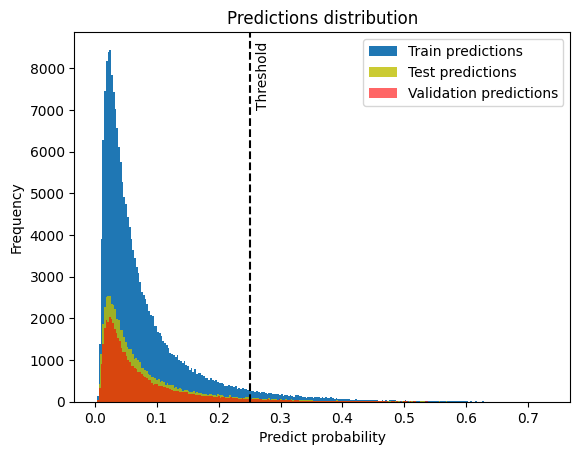

Test ROC AUC Score: 0.9849
Percentage difference Score (train - val): 3.1 %


In [8]:
train_predict_proba = base_model_pipeline.predict(X_train)
val_predict_proba = base_model_pipeline.predict(X_val)
test_predict_proba = base_model_pipeline.predict(X_test)

# Binarize Score
threshold = 0.25
train_predict = (train_predict_proba > threshold).astype(int)
val_predict = (val_predict_proba > threshold).astype(int)
test_predict = (test_predict_proba > threshold).astype(int)
y_test_real = (y_test > threshold).astype(int)

# ROC AUC Score
train_score = base_model_pipeline.score(X_train, y_train)
val_score = base_model_pipeline.score(X_val, y_val)
test_score = base_model_pipeline.score(X_test, y_test_real)
print()
print("Train ROC AUC Score: {:.4f}".format(train_score))
print("Validation ROC AUC Score: {:.4f}".format(val_score))

ax1 = pd.Series(train_predict_proba).plot(kind="hist", bins=255, alpha=1)
ax2 = pd.Series(test_predict_proba).plot(kind="hist", bins=255, alpha=0.8, color="y")
ax3 = pd.Series(val_predict_proba).plot(kind="hist", bins=255, alpha=0.6, color="r")
ax3.set_xlabel("Predict probability")
ax3.set_title("Predictions distribution")
ax3.legend(["Train predictions", "Test predictions", "Validation predictions"])
ax3.axvline(x=threshold, color="k", linestyle="--")
ax3.text(
    threshold + 0.01,
    7000,#  hardcoded
    "Threshold",
    rotation=90,
    verticalalignment="bottom",
    horizontalalignment="left",
    color="k",
    fontsize=10,
)
plt.show()


print("Test ROC AUC Score: {:.4f}".format(test_score))
diff = round((train_score - val_score) *100, 1)
print(f"Percentage difference Score (train - val): {diff} %")

# Feature Selection

In [21]:
base_lgbm_model = base_model_pipeline.named_steps["model"].model
relevant_features = base_lgbm_model.feature_importance() != 0

['__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_free_buffer',
 '_get_loaded_param',
 '_handle',
 '_network',
 '_train_data_name',
 'add_valid',
 'best_iteration',
 'best_score',
 'current_iteration',
 'dump_model',
 'eval',
 'eval_train',
 'eval_valid',
 'feature_importance',
 'feature_name',
 'free_dataset']

In [32]:
X = train_data.loc[:, relevant_features]
y = y_train

X_val, y_val = val_data.loc[:, relevant_features], y_val
X_test, y_test = test_data.loc[:, relevant_features], y_test_real

In [33]:
# import a logistic regresion model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

log_reg = LogisticRegression(random_state=42, C=0.001).fit(X, y)

log_reg_train = log_reg.predict_proba(X)[:, 1]
log_reg_val = log_reg.predict_proba(X_val)[:, 1]
log_reg_test = log_reg.predict_proba(X_test)[:, 1]

# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=log_reg_train)
roc_auc_val = roc_auc_score(y_true=y_val, y_score=log_reg_val)
roc_auc_test = roc_auc_score(y_true=y_test, y_score=log_reg_test)
print()
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")
print(f"Percentage difference Score (train - val): {round((roc_auc_train - roc_auc_val) *100, 1)} %")
print()
print("Test ROC AUC Score: {:.4f}".format(roc_auc_test))


Train ROC AUC Score: 0.7463
Validation ROC AUC Score: 0.7405
Percentage difference Score (train - val): 0.6 %

Test ROC AUC Score: 0.9850
